In [ ]:
!pip install gymnasium

In [ ]:
!pip install gymnasium[atari]

In [ ]:
!pip install gymnasium[accept-rom-license]

In [111]:
import torch
from random import sample
from torch.distributions import Normal

class DQN(torch.nn.Module):
    def __init__(self, taille_state, taille_action, lr = 3e-4, hidden = 24):
        super().__init__()
        self.taille_state = taille_state
        self.taille_action = taille_action
        self.lr = lr
        self.hidden = hidden
        self.net = torch.nn.Sequential(
                        torch.nn.Linear(self.taille_state, self.hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(self.hidden, self.hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(self.hidden, self.taille_action)
        )
        self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)
        self.f_loss = torch.nn.MSELoss()

    def forward(self, x):
        return self.net(x)
    
    def fit(self, x, y, epoch=10):
        for _ in range(epoch):
            y_hat = self.forward(x)
            loss = self.f_loss(y_hat, y)
            loss.backward()
            self.optim.step()
            self.optim.zero_grad()

    def updateParam(self, dqn):
        """
            Pour Target Network, copier les parametres d'autre DQN
        """
        self.load_state_dict(dqn.state_dict())

    def getNet(self):
        return self.net

class Critic(torch.nn.Module):
    def __init__(self, taille_state, taille_action, hidden):
        super().__init__()
        self.taille_state = taille_state
        self.taille_action = taille_action
        self.hidden = hidden
        self.net = torch.nn.Sequential(
                        torch.nn.Linear(self.taille_state, self.hidden[0]),
                        torch.nn.ReLU(),
                        torch.nn.Linear(self.hidden[0], self.hidden[1]),
                        torch.nn.ReLU(),
                        torch.nn.Linear(self.hidden[1], self.taille_action)
        )

    def forward(self, x):
        return self.net(x)
    
    def getNet(self):
        return self.net


class Actor(torch.nn.Module):
    def __init__(self, taille_state, taille_action, hidden, out=0):
        super().__init__()
        self.taille_state = taille_state
        self.taille_action = taille_action
        self.hidden = hidden
        if out == 0:
            self.net = torch.nn.Sequential(
                            torch.nn.Linear(self.taille_state, self.hidden[0]),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden[0], self.hidden[1]),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden[1], self.taille_action),
                            torch.nn.Tanh() # lunar action [-1,1]
            )
        else:
            self.net = torch.nn.Sequential(
                            torch.nn.Linear(self.taille_state, self.hidden[0]),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden[0], self.hidden[1]),
                            torch.nn.ReLU(),
                            torch.nn.Linear(self.hidden[1], self.taille_action),
                            torch.nn.Softmax()
            )
    def forward(self, x):
        return self.net(x)

    def getNet(self):
        return self.net



# Just to test Optimal Actor, forgot to change name when training ...
# class NNActor(torch.nn.Module):
#     def __init__(self, taille_state, taille_action, lr = 0.00025, hidden = 256):
#         super().__init__()
#         self.taille_state = taille_state
#         self.taille_action = taille_action
#         self.lr = lr
#         self.hidden = hidden
#         self.net = torch.nn.Sequential(
#                         torch.nn.Linear(self.taille_state, 256),
#                         torch.nn.ReLU(),
#                         torch.nn.Linear(256, 256),
#                         torch.nn.ReLU(),
#                         torch.nn.Linear(256, self.taille_action),
#                         torch.nn.Tanh() # lunar action [-1,1]
#         )
#         self.optim = torch.optim.Adam(self.parameters(), lr = self.lr)
#         self.f_loss = torch.nn.MSELoss()

#     def forward(self, x):
#         return self.net(x)

#     def getNet(self):
#         return self.net

class Buffer:
    def __init__(self, taille_max):
        self.taille = taille_max
        self.memoire = []
        self.last100 = []
        self.mean = []
        
    def getLen(self):
        return len(self.memoire)
      
    def getLastMean(self):
        return self.mean[-1]
    
    def add(self, element):
        if self.getLen() >= self.taille:
            del self.memoire[0]
        self.memoire.append(element)

    def sampleState(self, taille_sample):
        return sample(self.memoire, taille_sample)

    def addReward(self, reward):
        if len(self.last100) >= 100:
            del self.last100[0]
        self.last100.append(reward)
        self.mean.append(sum(self.last100)/len(self.last100))
    
def addGaussianNoise(action, sigma=0.1):
    a = torch.tensor(action)
    dist = Normal(a, sigma)
    return dist.sample().detach().numpy()




In [128]:
cfgDDGP = {
    "len_buffer" : 100000,
    "batch" : 64,
    "gamma" : 0.99,
    "tau" : 0.001,
    "explore": 1.0,
    "explore_min": 0.01,
    "explore_decay": 0.995,
    "noise": 0.1,
    "noise_decay_step": 5000,
    "start_learning_step": 10000,
    "lr" : {
        "critic" : 0.0002,
        "actor" : 0.0003
    },
    "hidden_layer" : {
        "critic" : [256,256],
        "actor" : [256, 256]
    }
}

cfgA2C1step = {
    "entropy": False,
    "gamma" : 0.99,
    "beta" :0.9,
    "lr" : {
        "critic" : 1e-3,
        "actor" : 1e-3
    },
    "hidden_layer" : {
        "critic" : [64,32],
        "actor" : [64, 32]
    }
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
from numpy import e
import os
import sys
import copy as cp
from torch.distributions.uniform import Uniform
from torch.distributions import Categorical

sys.path.append(os.path.abspath("../Network"))

class Agent():
    def __init__(self, env):
        self.env = env
    
    def act(self, obs):
        pass

    def store(self, obs, action, new_obs, reward):
        pass

class AgentRandom(Agent):
    def __init__(self, env):
        super().__init__(env)

    def act(self, obs):
        return self.env.action_space.sample()

    def store(self, obs, action, new_obs, reward):
        pass

class AgentPolicy(Agent):
    def __init__(self, env, pi):
        super().__init__(env)
        self.pi = pi

    def act(self, obs):
        return self.pi[obs]

    def store(self, obs, action, new_obs, reward):
        pass

class AgentDQN(Agent):
    def __init__(self,env, gamma=0.99, batch=32):
        super().__init__(env)
        self.taille_state = self.env.observation_space.shape[0] #Box
        self.taille_action = self.env.action_space.n
        self.batch_size = batch
        self.buffer = Buffer(5*self.batch_size)
        # NN
        self.dqn = DQN(self.taille_state, self.taille_action)
        # Hyper-param
        self.explore = 1.0
        self.explore_min = 0.01
        self.explore_decay = 0.995
        self.gamma = gamma
        
    def act(self, state):
        if torch.rand(1).item() < self.explore: # solf greedy
            return torch.randint(0, self.taille_action, (1,)).item()
        return torch.argmax(self.dqn(state)).item()
    
    def act_opt(self, state):
        return torch.argmax(self.dqn(state)).item()
    
    def setDQN(self, path):
        self.dqn = torch.load(path)

    def store(self, state, reward, action, done,  state_suivant):
        self.buffer.add([state, reward, action, done, state_suivant])

    def replay(self, batch_seuil, decay):
        if self.buffer.getLen() < batch_seuil:
            return
        mini_batch = self.buffer.sampleState(self.batch_size)
        for state, reward, action, done, state_suivant in mini_batch:
            y_action = reward + self.gamma*torch.max(self.dqn.forward(state_suivant)).detach().item()
            if done:
                y_action = reward # bah, si done -> perdu donc faut savoir pour eviter
            y = self.dqn.forward(state)
            y[0][action] = y_action # tel action amene a tel score
            self.dqn.fit(state, y, epoch=1) 
        if decay and self.explore > self.explore_min:
            self.explore *= self.explore_decay

class AgentDQN_TargetNetwork(AgentDQN):
    def __init__(self, env, gamma=0.99, batch=32, K=32):
        super().__init__(env, gamma, batch)
        self.K = K # nombre de pas pour maj Target Network
        self.counterK = 0 
        self.dqnTarget = cp.deepcopy(self.dqn)

    def replay(self, batch_seuil, decay):
        if self.buffer.getLen() < batch_seuil:
            return
        mini_batch = self.buffer.sampleState(self.batch_size)
        for state, reward, action, done, state_suivant in mini_batch:
            # target est calculé par Target Network
            y_action = reward + self.gamma*torch.max(self.dqnTarget.forward(state_suivant)).detach().item()
            if done:
                y_action = reward # bah, si done -> no more futur
            y = self.dqnTarget.forward(state)
            y[0][action] = y_action # tel action amene a tel score, 1 batch, tensor donc [0] ..
            # MAJ Q-network
            self.dqn.fit(state, y, epoch=1)
            self.counterK += 1
            # Update target network every K steps ...
            if self.counterK == self.K:
                self.dqnTarget.updateParam(self.dqn)
                self.counterK = 0 # reset counter, ugly code ...
        if decay and self.explore > self.explore_min:
            self.explore *= self.explore_decay



class AgentDDPG(Agent):
    def __init__(self, env, config):
        super().__init__(env)
        # continuous environment
        assert env.continuous == True
        # param env
        if env.unwrapped.spec.id == "LunarLander-v2":
            self.taille_state = self.env.observation_space.shape[0] #Box
            self.taille_action = self.env.action_space.shape[0] #Box
        # Neural networks
        self.Critic = Critic(self.taille_state + self.taille_action, 1, config["hidden_layer"]["critic"])
        self.CriticTarget = cp.deepcopy(self.Critic)
        self.Actor = Actor(self.taille_state , self.taille_action, config["hidden_layer"]["actor"]) # I make only 1 actor here
        self.ActorTarget = cp.deepcopy(self.Actor)
        # Optim
        self.optCritic = torch.optim.Adam(self.Critic.parameters(), config["lr"]["critic"]) # optim Critic
        self.optActor = torch.optim.Adam(self.Actor.parameters(), config["lr"]["actor"]) # optim Actor
   
        # Loss
        self.f_loss = torch.nn.MSELoss()
        # Hyper-param
        self.batch_size = config["batch"]
        self.buffer = Buffer(config["len_buffer"])
        self.explore = config["explore"]
        self.explore_min = config["explore_min"]
        self.explore_decay = config["explore_decay"]
        self.gamma = config["gamma"]
        self.tau = config["tau"] # Tau to update Target Network
        self.sigma = config["noise"] # noise
        self.decay_sigma = config["noise_decay_step"]
        self.step_count = 0
        self.start_learning = config["start_learning_step"]

    def act(self, state):
        self.step_count += 1
        if torch.rand(1).item() < self.explore: # solf greedy
            if self.env.unwrapped.spec.id == "LunarLander-v2":
                return np.random.uniform(-1,1,(2,)) # np.array([main, lateral])
        if self.step_count>0 and self.step_count%self.decay_sigma==0: #decay noise every 5000 steps
            self.sigma *= 0.95
        a = self.Actor(state)[0].cpu().detach().numpy()
        a = addGaussianNoise(a, self.sigma)
        return a
    
    def act_opt(self, state): # 1 actor
        return self.Actor(state)[0].detach().numpy()
    
    def saveActor(self, path):
        torch.save(self.Actor, path)
    
    def setActor(self, path): 
        self.Actor = torch.load(path)

    def addReward(self, reward):
        """
            Tracking last N-reward
        """
        self.buffer.addReward(reward)
        return self.buffer.getLastMean()

    def store(self, state, reward, action, done,  state_suivant):
        self.buffer.add([state, reward, action, done, state_suivant])

    def updateTargetDDPG(self):
        # critic
        for param, target_param in zip(self.Critic.parameters(), self.CriticTarget.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        # actor
        for param, target_param in zip(self.Actor.parameters(), self.ActorTarget.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def updateNetworks(self, state, reward, action, done, state_suivant):
        assert list(state.shape) == [1, self.taille_state]
        assert list(action.shape) == [1, self.taille_action]
        state_suivant.requires_grad = True # to update Actor
        # prepare data actor
        outActor_suivant = self.ActorTarget.forward(state_suivant) # pi(state_suivant)
        # prepare data critic
        input_Q = torch.hstack((state, action))
        input_Q_suivant = torch.hstack((state_suivant, outActor_suivant)) 
        #
        Q = self.Critic.forward(input_Q) # y_hat
        Q_suivant = self.CriticTarget.forward(input_Q_suivant)
        y = reward + self.gamma*Q_suivant
        if done:
            y = torch.tensor(reward, dtype=torch.float32).view(1,-1)
        # Critic, 1 epoch
        loss = self.f_loss(Q, y)
        self.optCritic.zero_grad()
        loss.backward()
        self.optCritic.step()

    def replay(self, decay):
        if self.buffer.getLen() < self.start_learning:
            return
        mini_batch = self.buffer.sampleState(self.batch_size)
        batch_state = []
        for state, reward, action, done, state_suivant in mini_batch:
            batch_state.append(state.squeeze(0))
            self.updateNetworks(state, reward, action, done, state_suivant)
        batch_state = torch.stack(batch_state)
        # Actor
        outActor = self.Actor.forward(batch_state)
        intputQ_actor_update = torch.hstack((batch_state, outActor))
        lossActor = -self.Critic(intputQ_actor_update).mean() # if Q is bad -> loss is positif, Q is good -> loss is neg (good thing)
        self.optActor.zero_grad()
        lossActor.backward()
        self.optActor.step()
        # Target
        self.updateTargetDDPG()
        if decay and self.explore > self.explore_min:
            self.explore *= self.explore_decay

class AgentA2C_1step(Agent):
    def __init__(self, env, config):
        super().__init__(env)
        # entropy ou pas
        self.useEntropy = config["entropy"]
        # param env
        if env.unwrapped.spec.id == "CartPole-v1":
            self.taille_state = self.env.observation_space.shape[0] #Box
            self.taille_action = self.env.action_space.n #discrete
            # Neural networks
            self.Critic = Critic(self.taille_state, 1, config["hidden_layer"]["critic"])
            self.Actor = Actor(self.taille_state , self.taille_action, config["hidden_layer"]["actor"], out = 1) # out 1 softmax
            self.optCritic = torch.optim.Adam(self.Critic.parameters(), config["lr"]["critic"]) # optim Critic
            self.optActor = torch.optim.Adam(self.Actor.parameters(), config["lr"]["actor"]) # optim Actor
            self.lossCritic = torch.nn.MSELoss()
        # hyper param
        self.gamma = config["gamma"]
        self.beta = config["beta"] # entropy

    def act(self, state, mode=0):
        """
            mode: 0 stochastics, 1 max
        """
        proba = self.Actor(state)
        if mode == 1:
            return proba, proba.argmax(1)
        return proba, Categorical(proba).sample()
    
    def updateNetworks(self, state, reward, action, done, state_suivant, dist):
        # critic
        Q = reward + (1-done)*self.gamma*self.Critic.forward(state_suivant) - self.Critic.forward(state)
        V = self.Critic.forward(state)

        A = Q - V
        # actor

        loss = self.lossCritic(V, Q)
        self.optCritic.zero_grad()
        loss.backward()
        self.optCritic.step()

        # actor
        if self.useEntropy:
          loss_actor = -dist.log_prob(action)*(A.detach() - self.beta*dist.entropy().item())
        else:
          loss_actor = -dist.log_prob(action)*(A.detach())
        self.optActor.zero_grad()
        loss_actor.backward()
        self.optActor.step()






In [137]:
import gymnasium as gym
import math

if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    nb_episode = 5000
    r = []
    agent = AgentA2C_1step(env, cfgA2C1step)
    for i in tqdm(range(nb_episode)):
        state, _ = env.reset()
        state = torch.from_numpy(state).float()
        cum_reward = 0
        for frame in range(100000):
            proba, action = agent.act(state)
            dist = Categorical(proba)
            state_suivant, reward, done, _, info = env.step(action.detach().data.numpy())
            state_suivant = torch.from_numpy(state_suivant).float()
            #transform action 
            agent.updateNetworks(state, reward, action, done, state_suivant, dist)
            cum_reward += reward
            if done:
                r.append(cum_reward)
                break
            state = torch.tensor(state_suivant)



  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-137-064dfee97fa8>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state_suivant)
100%|██████████| 5000/5000 [06:46<00:00, 12.31it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

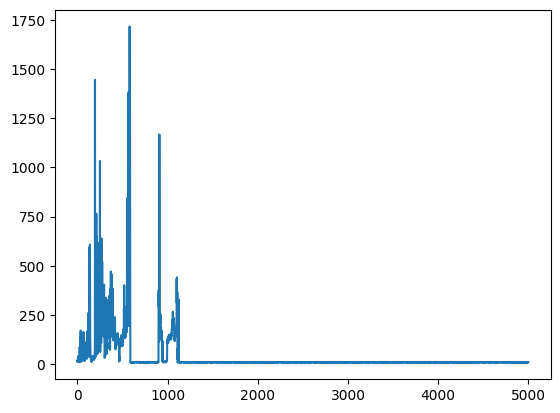

In [138]:
import numpy as np
import matplotlib.pyplot as plt

epi = np.arange(nb_episode)
rw = np.array(r)

plt.plot(epi,rw)
plt.show